In [1]:
from field_matching_utils import *
from io_utils import *
from score_utils import *


### Metadata files
VinDr metadata on Luna: `'/projects01/didsr-aiml/common_data/VinDr-Mammo/raw-images/vindr-mammo/1.0.0/metadata.csv'`

InBreast metadata on Luna: `'/projects01/didsr-aiml/common_data/InBreast/INbreast.csv'`

WSI: `'/projects01/didsr-aiml/tahsin.rahman/dcard-completeness/data_files/Master patient list for FDA 3-4-22.xlsx'`

### Merged metadata files
Digital Mammography - VinDr: `'/projects01/didsr-aiml/tahsin.rahman/dcard-completeness/data_files/VinDr_merged_metadata.csv'`

WSI: `'/projects01/didsr-aiml/tahsin.rahman/dcard-completeness/data_files/WashU_merged_metadata.csv'`


Assessing completeness for metadata file 'metadata.csv'
Required Header		Matched Dataset Header
---------------------------------------------
Patient Birth Date/Age	Patient's Age
Breast Orientation  	View Position
Laterality          	Image Laterality
Image Dimension     	Rows        
Pixel Spacing       	Imager Pixel Spacing
Manufacturer        	Manufacturer
Manufacturer/Model  	Manufacturer's Model Name

Missing Headers: ['Patient ID', 'Patient Sex', 'History/Prior', 'Race', 'Ethnicity', 'History/Family', 'Marital status', 'ZIP Code', 'Study ID', 'Study Date', 'Study Time', 'Modality', 'Image Type', 'Image ID', 'Resolution', 'File Format', 'Compression Type', 'Bits Stored', 'Manufacturer/Year', 'Manufacturer/Regulatory']

Unexpected Headers: ['SOP Instance UID', 'Series Instance UID', 'SOP Instance UID.1', 'Photometric Interpretation', 'Columns', 'Pixel Spacing', 'Pixel Padding Value', 'Pixel Padding Range Limit', 'Window Center', 'Window Width', 'Rescale Intercept', 'Rescale Slope',

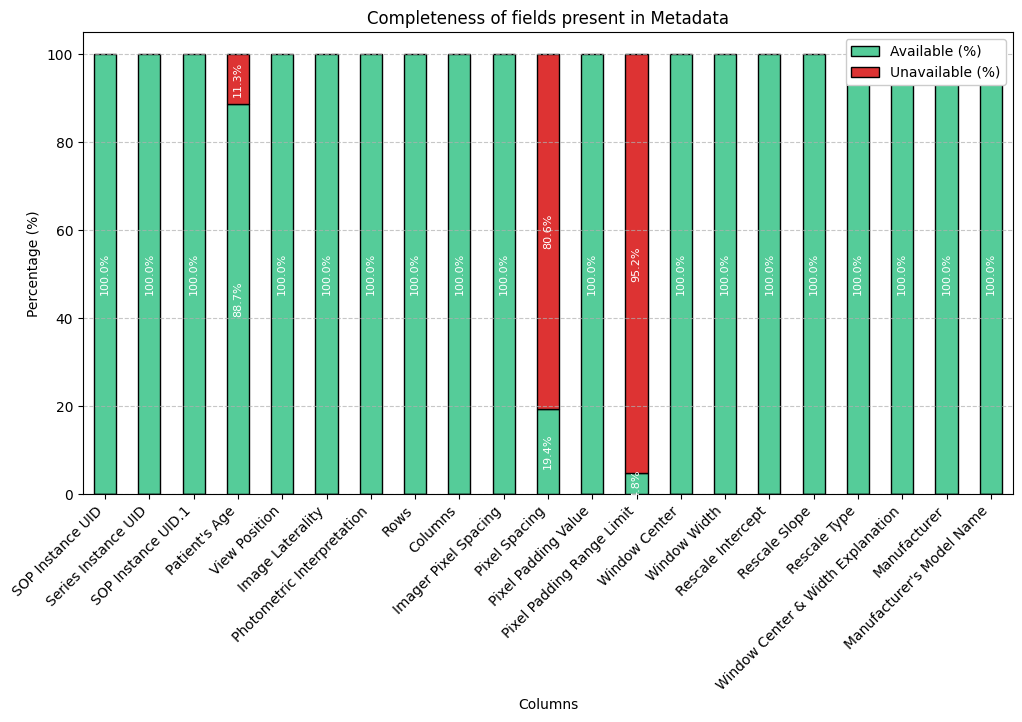

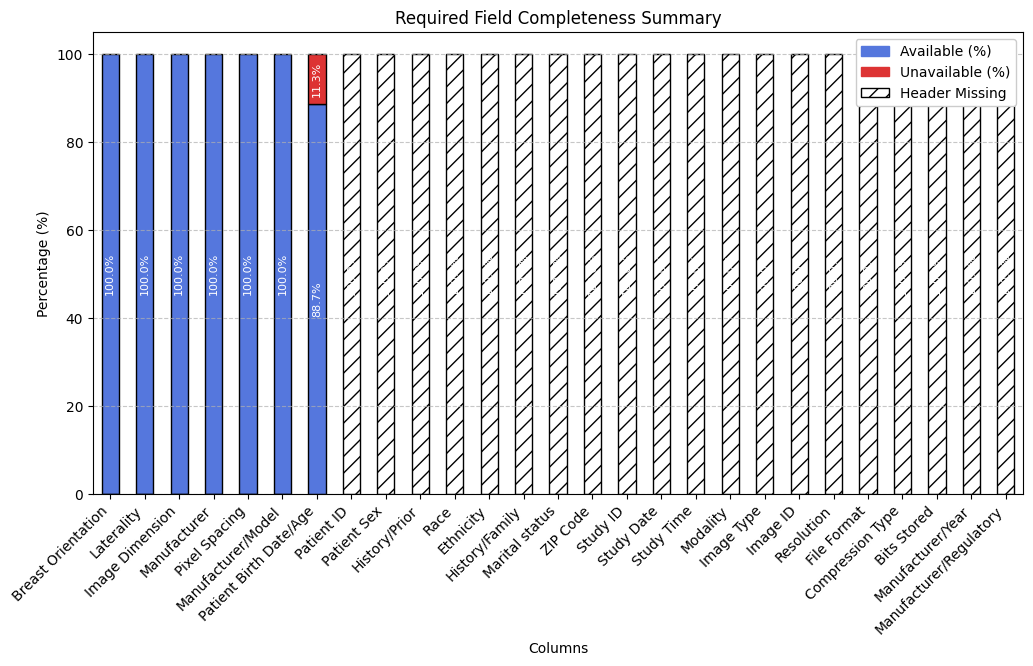

In [5]:
# File paths
metadata_reference_path = 'data/dm_metadata_dictionary2.json'
completeness_check_level = 'Core Fields'
metadata_file_path ='/projects01/didsr-aiml/common_data/VinDr-Mammo/raw-images/vindr-mammo/1.0.0/metadata.csv'

# Create output directory to store visualizations
os.makedirs('output', exist_ok=True)

# Load required metadata fields from a json dictionary and retrieve the list of aliases for each field.
metadata_reference_dictionary = get_dictionary(metadata_reference_path,completeness_check_level)
field_aliases = get_field_item(metadata_reference_dictionary)
required_fields = list(field_aliases.keys())

# Load the dataset metadata
# This step loads the dataset metadata (a multi-column CSV/XLS file) into a pandas DataFrame.
# Each column represents a metadata attribute (e.g., 'PatientID', 'Modality'), and each row represents a data point.
metadata_df = load_metadata_file(metadata_file_path)

if metadata_df is not None:
    print(f"Assessing completeness for metadata file '{os.path.basename(metadata_file_path)}'")

"""
Perform dataset-level completeness check
This checks if the dataset's headers (column names) match the required fields.
- Missing Headers: Required fields that are not present in the dataset.
- Unexpected Headers: Fields present in the dataset that are not part of the required fields.

The field_matching_methods dictionary consists of a set of matching methods that are executed in order.
The value for each method is a tuple in which the first item is a flag to enable/disable the method
and the second item contains any additional parameters needed for that method (or None).
`UA` refers to User-Assisted. Enabling this method will use either fuzzy matching or token matching using a language model
to return likely matches for header fields that could not be automatically matched.
For each such field, the user will receive a prompt to select a field from one of the top N most likely options (specified by 'limit').
The token matching option is disabled in this version of the code.
"""

field_matching_methods = {
    'strict':(False,None),
    'dictionary':(True,{'field_dictionary':field_aliases}),
    'soft': (False,None),
    'fuzzy': (False,{'threshold':80}),
    'UA':(False,{'ranking_method':'fuzzy','limit':4})  # 'fuzzy' or 'LM'
}

if metadata_df is not None and required_fields:
    completeness_report = dataset_level_completeness_check(metadata_df, required_fields, field_matching_methods)

    # Extract missing and unexpected headers for clarity
    available_header_map = completeness_report["available_header_map"]
    missing_headers = completeness_report["missing_headers"]
    unexpected_headers = completeness_report["unexpected_headers"]
    completeness_score = completeness_report["completeness_score"]

    # Show header mapping
    # If there are required fields missing from the dataset, list them.
    if available_header_map:
        print('Required Header\t\tMatched Dataset Header')
        print('---------------------------------------------')
        for k,v in available_header_map.items():
            print('{:<20}\t{:<12}'.format(k,v))
    else:
        print(f"All required fields are missing for {completeness_check_level}.")

    # Step 4: Report Missing Headers
    # If there are required fields missing from the dataset, list them.
    if missing_headers:
        print(f"\nMissing Headers: {missing_headers}\n")
    else:
        print("No missing headers. All required fields are present.")

    # Step 5: Report Unexpected Headers
    # If the dataset contains extra fields not listed in the required fields, list them.
    if unexpected_headers:
        print(f"Unexpected Headers: {unexpected_headers}\n")
    else:
        print("No unexpected headers. All dataset fields are required.")

    # Step 6: Report Completeness Score
    print(f"Completeness Score: {completeness_score:.2f}")

    # Step 7: Perform record-level completeness check
    # This checks individual columns and rows in the metadata file and reports completion information
    record_level_results = record_level_completeness_check(metadata_df, required_fields, available_header_map,visualize=True,savefig=False)
else:
    # Handle cases where either the dataset or required fields failed to load.
    print("Failed to load dataset or required fields.")